# Setup

In [ ]:
# Install necessary libraries
!pip install langchain-openai yfinance PyPortfolioOpt

In [ ]:
## Libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import yfinance as yf
from langchain_openai import ChatOpenAI
from scipy.optimize import minimize
from pypfopt import risk_models, expected_returns, BlackLittermanModel, EfficientFrontier, black_litterman

In [ ]:
# Function to initialize OpenAI LLM model
def initialize_llm(api_key):
    """
    Initialize the ChatOpenAI language model.

    Parameters:
    api_key (str): The API key for accessing the OpenAI service.

    Returns:
    ChatOpenAI: The initialized language model.
    """
    llm = ChatOpenAI(model="gpt-4o", temperature=0, api_key=api_key)
    return llm


In [ ]:
# Function to calculate start and end dates based on the number of years from today
def calculate_date_range(years):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=years * 365)
    return start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')


In [ ]:
# Function to invoke LLM response based on given prompt
def get_llm_response(llm, prompt):
    """
    Get the response from the language model for a given prompt.

    Parameters:
    llm (ChatOpenAI): The initialized language model.
    prompt (str): The prompt to send to the language model.

    Returns:
    str: The content of the language model's response.
    """
    response = llm.invoke(prompt)
    return display(Markdown(response.content))

In [ ]:
# Plots the RSI for a given stock and highlights overbought and oversold thresholds.
def plot_rsi(data, ticker):
    """
    Plot the Relative Strength Index (RSI) for a given stock.

    Parameters:
    data (DataFrame): The stock data.
    ticker (str): The stock ticker symbol.

    Returns:
    None
    """
    # Define the lookback window for RSI calculation
    window = 14

    # Ensure we are working with a Series for 'Close' price
    close_prices = data['Close'].squeeze()

    # Calculate the RSI
    delta = close_prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    # Plot the RSI
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, rsi, label='RSI', color='purple')
    plt.axhline(70, color='red', linestyle='--')        # Add a horizontal line at RSI = 70 (overbought threshold)
    plt.axhline(30, color='green', linestyle='--')      # Add a horizontal line at RSI = 30 (oversold threshold)

    # Add title, labels, and legend
    plt.title(f'RSI of {ticker}')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.show()

In [ ]:
# Plot Bollinger Bands, including the closing price, middle band (SMA), and upper/lower bands (±2 standard deviations).
def plot_bollinger_bands(data, ticker):
    """
    Plot the Bollinger Bands for a given stock.

    Parameters:
    data (DataFrame): The stock data.
    ticker (str): The stock ticker symbol.

    Returns:
    None
    """
    # Define the rolling window period for Bollinger Bands
    window = 20

    # Ensure we are working with a Series for 'Close' price
    close_prices = data['Close'].squeeze()

    # Calculate the middle band (simple moving average) and outer bands (±2 standard deviations)
    middle_band = close_prices.rolling(window=window).mean()
    std_dev = close_prices.rolling(window=window).std()

    data['Middle Band'] = middle_band
    data['Upper Band'] = middle_band + 2 * std_dev
    data['Lower Band'] = middle_band - 2 * std_dev

    # Plot the closing price and Bollinger Bands
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, close_prices, label='Closing Price')  # Plot closing price
    plt.plot(data.index, data['Middle Band'], label='Middle Band', color='blue')  # Plot middle band
    plt.plot(data.index, data['Upper Band'], label='Upper Band', color='red')  # Plot upper band
    plt.plot(data.index, data['Lower Band'], label='Lower Band', color='green')  # Plot lower band

    # Add title, labels, and legend
    plt.title(f'Bollinger Bands of {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [ ]:
# Plots the Price-to-Earnings (P/E) ratios over time for a list of stocks, using their historical closing prices and trailing EPS.
def plot_pe_ratios(data, ticker, eps):
    """
    Plot the Price-to-Earnings (P/E) ratio for a given stock.

    Parameters:
    data (DataFrame): The stock data.
    ticker (str): The stock ticker symbol.
    eps (float): The earnings per share of the stock.

    Returns:
    None
    """
    # Check if EPS value is valid
    if eps is None or eps == 0:
        print(f"Warning: EPS for {ticker} is not available or zero. PE ratio can't be calculated.")
        return

    # Calculate the P/E ratio
    pe_ratio = data['Close'] / eps

    # Create and customize the plot
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, pe_ratio, label=f'{ticker} PE Ratio')
    plt.title('PE Ratios of Selected Stocks')
    plt.xlabel('Date')
    plt.ylabel('PE Ratio')
    plt.legend()
    plt.show()


In [ ]:
# Plots a bar chart comparing beta values of the given stock tickers.
def plot_beta_comparison(tickers, start_date, end_date):
    betas = {}

    for ticker in tickers:
        stock = yf.Ticker(ticker)
        try:
            # Retrieve historical data
            data = stock.history(start=start_date, end=end_date)
            # Get the beta value from stock's info
            beta = stock.info.get('beta')

            # Skip to the next ticker if beta is not available
            if beta is None:
                print(f"Warning: Beta for {ticker} is not available.")
                continue

            betas[ticker] = beta # Store the beta value

        # Handle errors related to missing data
        except KeyError as e:
            print(f"Error retrieving data for {ticker}: {e}")
        # Handle other unexpected errors
        except Exception as e:
            print(f"An error occurred with ticker {ticker}: {e}")

    # Plotting the bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(betas.keys(), betas.values(), color='blue')
    plt.title('Beta Comparison of Selected Stocks')
    plt.xlabel('Ticker')
    plt.ylabel('Beta')
    plt.show()

In [ ]:
# Plots the MACD and signal line for each ticker to show momentum trends.
def plot_macd(data, ticker):
    """
    Plot the Moving Average Convergence Divergence (MACD) for a given stock.

    Parameters:
    data (DataFrame): The stock data.
    ticker (str): The stock ticker symbol.

    Returns:
    None
    """
    # Ensure we are working with a Series for 'Close' price
    close_prices = data['Close'].squeeze()

    # Calculate the 12-day and 26-day EMA
    ema_12 = close_prices.ewm(span=12, adjust=False).mean()
    ema_26 = close_prices.ewm(span=26, adjust=False).mean()

    # Calculate the MACD
    macd = ema_12 - ema_26

    # Calculate the signal line
    signal = macd.ewm(span=9, adjust=False).mean()

    # Plot MACD and signal line
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, macd, label=f'{ticker} MACD')
    plt.plot(data.index, signal, label=f'{ticker} Signal Line')
    plt.title(f'MACD and Signal Line of {ticker}')
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.legend()
    plt.show()

In [ ]:
# Calculates and returns key performance indicators (RSI, Bollinger Bands, P/E Ratio, Beta, and MACD) for a list of stock tickers over a specified date range.
def calculate_kpis(tickers, start_date, end_date):
    """
    Calculate KPIs for a list of stocks over a given time period.

    Parameters:
    tickers (list): A list of stock ticker symbols.
    start_date (str): The start date for the analysis.
    end_date (str): The end date for the analysis.

    Returns:
    dict: A dictionary containing the KPIs for each stock.
    """
    kpi_data = {}
    for ticker in tickers:
        # Download historical stock data
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)
        kpi_data[ticker] = {}

        # Calculate RSI
        delta = data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()      # Average gains
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()     # Average losses
        rs = gain / loss                                                  # Relative strength
        rsi = 100 - (100 / (1 + rs))                                      # RSI formula
        kpi_data[ticker]['RSI'] = rsi

        # Calculate Bollinger Bands
        middle_band = data['Close'].rolling(window=20).mean()                     # Middle band (SMA)
        upper_band = middle_band + 2 * data['Close'].rolling(window=20).std()     # Upper band
        lower_band = middle_band - 2 * data['Close'].rolling(window=20).std()     # Lower band
        kpi_data[ticker]['Bollinger Bands'] = {
            'Middle Band': middle_band,
            'Upper Band': upper_band,
            'Lower Band': lower_band
        }

        # Calculate P/E Ratio
        try:
            eps = stock.info.get('trailingEps') # Get trailing EPS
            if eps and eps != 0:
                pe_ratio = data['Close'] / eps
                kpi_data[ticker]['P/E Ratio'] = pe_ratio # Calculate P/E ratio
            else:
                kpi_data[ticker]['P/E Ratio'] = None
        except Exception as e:
            kpi_data[ticker]['P/E Ratio'] = None
            print(f"An error occurred with ticker {ticker} P/E Ratio: {e}")

        # Calculate Beta
        try:
            beta = stock.info.get('beta') # Get beta value
            kpi_data[ticker]['Beta'] = beta
        except Exception as e:
            kpi_data[ticker]['Beta'] = None
            print(f"An error occurred with ticker {ticker} Beta: {e}")

        # Calculate MACD
        ema_12 = data['Close'].ewm(span=12, adjust=False).mean()    # 12-day EMA
        ema_26 = data['Close'].ewm(span=26, adjust=False).mean()    # 26-day EMA
        macd = ema_12 - ema_26    # MACD line
        signal = macd.ewm(span=9, adjust=False).mean()   # Signal line
        kpi_data[ticker]['MACD'] = {
            'MACD': macd,
            'Signal Line': signal
        }

    return kpi_data


# API KEY

In [ ]:
# The API key for accessing the OpenAI service
api_key = "MY_API_KEY" # insert here your key

# Inputs

In [ ]:
# Intialize OpenAI LLM
llm = initialize_llm(api_key=api_key)

In [ ]:
# Define the number of years for the analysis
years = 2  # Example: 2 years

In [ ]:
# List of assets to analyze
assets = [
    "Apple (AAPL)",
    "Amazon (AMZN)",
    "Bitcoin (BTC-USD)",
    "Alphabet (GOOGL)",
    "Meta (META)",
    "Microsoft (MSFT)",
    "Nvidia (NVDA)",
    "S&P 500 index (SPY)",
    "Tesla (TSLA)"
]

In [ ]:
# Query to fetch and sort tickers alphabetically from a list of specified assets
query = f"""
fetch me the tickers from the following assets: {assets}
Your output must be sorted alhabetically by the ticker and it should be like this:
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']
"""

In [ ]:
# Feed prompt to LLM model, and invoke response
get_llm_response(llm = llm, prompt = query)

```python
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']
```

In [ ]:
# Convert asset names to their ticker symbols
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']

In [ ]:
# Calculate the start and end dates
start_date, end_date = calculate_date_range(years)

# Fetch historical stock data using yfinance
data = yf.download(tickers, start=start_date, end=end_date)

# Display the first few rows of the fetched data
data.head()


/tmp/ipython-input-744654986.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  9 of 9 completed


Price            Close                                                    \
Ticker            AAPL        AMZN       BTC-USD       GOOGL        META   
Date                                                                       
2023-08-05         NaN         NaN  29042.126953         NaN         NaN   
2023-08-06         NaN         NaN  29041.855469         NaN         NaN   
2023-08-07  177.077042  142.220001  29180.578125  130.745865  314.832825   
2023-08-08  178.017624  139.940002  29765.492188  130.616638  310.934204   
2023-08-09  176.423599  137.850006  29561.494141  128.887009  303.544708   

Price                                                            High  ...  \
Ticker            MSFT       NVDA         SPY        TSLA        AAPL  ...   
Date                                                                   ...   
2023-08-05         NaN        NaN         NaN         NaN         NaN  ...   
2023-08-06         NaN        NaN         NaN         NaN         NaN  ...   
2023-08-07  325.055511  45.389069  439.024567  251.449997  181.314612  ...   
2023-08-08  321.057709  44.636532  437.115387  249.699997  178.482966  ...   
2023-08-09  317.296173  42.527832  434.193176  242.190002  179.136428  ...   

Price             Open      Volume                                       \
Ticker            TSLA        AAPL        AMZN      BTC-USD       GOOGL   
Date                                                                      
2023-08-05         NaN         NaN         NaN   6598366353         NaN   
2023-08-06         NaN         NaN         NaN   7269806994         NaN   
2023-08-07  251.449997  97576100.0  71213100.0  13618163710  22746300.0   
2023-08-08  247.449997  67823000.0  51710500.0  17570561357  23535200.0   
2023-08-09  250.869995  60378500.0  50017300.0  18379521213  24912900.0   

Price                                                                     
Ticker            META        MSFT         NVDA         SPY         TSLA  
Date                                                                      
2023-08-05         NaN         NaN          NaN         NaN          NaN  
2023-08-06         NaN         NaN          NaN         NaN          NaN  
2023-08-07  16236500.0  17741500.0  322154000.0  58357500.0  111097900.0  
2023-08-08  15183500.0  22327600.0  353843000.0  71361300.0   96642200.0  
2023-08-09  19955800.0  22373300.0  586449000.0  78789600.0  101596300.0  

[5 rows x 45 columns]

# Outputs

### RSI

**What is RSI:** The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. RSI values above 70 indicate that a stock may be overbought, while values below 30 suggest it may be oversold.

**How to Interpret:** High RSI values (>70) indicate overbought conditions, potentially signaling a sell opportunity. Low RSI values (<30) indicate oversold conditions, potentially signaling a buy opportunity.

/tmp/ipython-input-3217521631.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


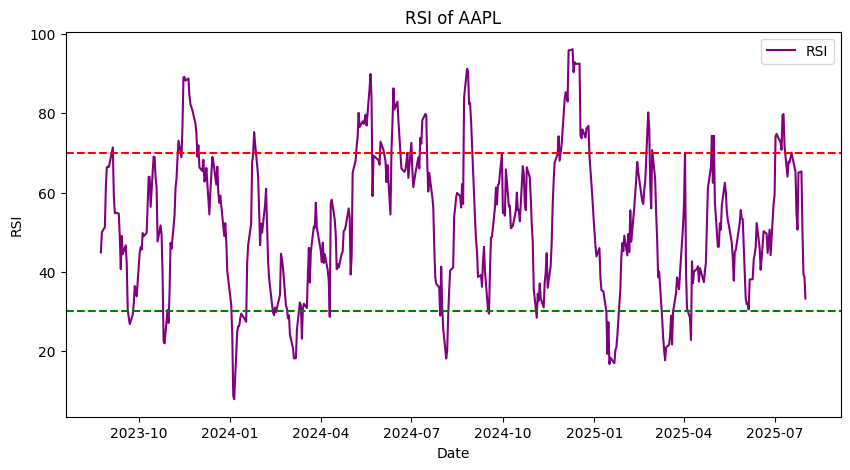

/tmp/ipython-input-3217521631.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


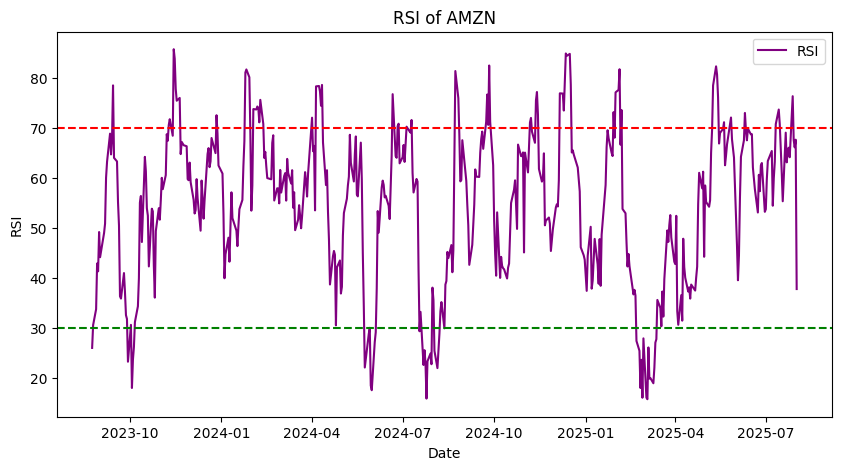

/tmp/ipython-input-3217521631.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


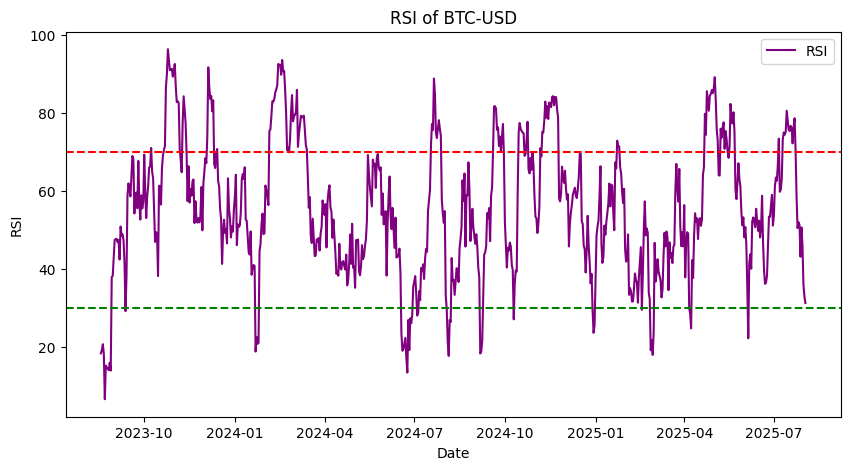

/tmp/ipython-input-3217521631.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


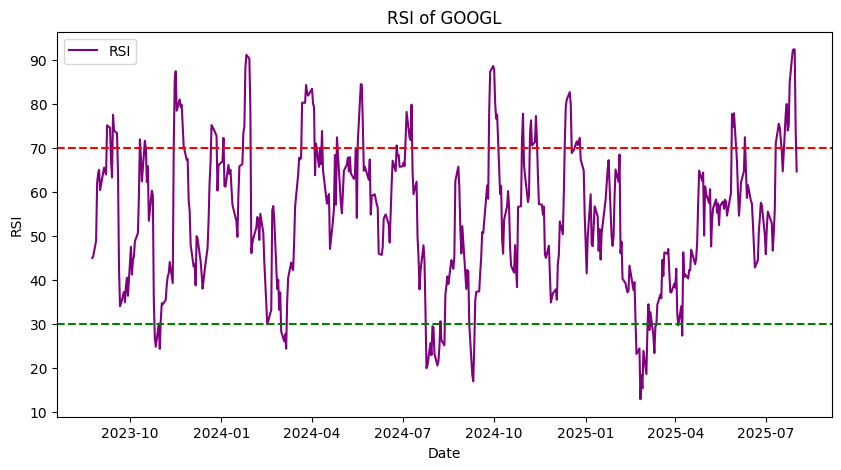

/tmp/ipython-input-3217521631.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


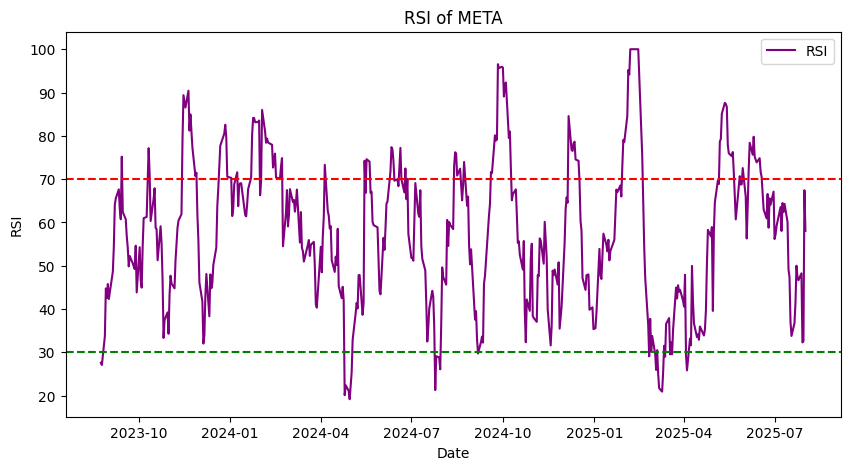

/tmp/ipython-input-3217521631.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


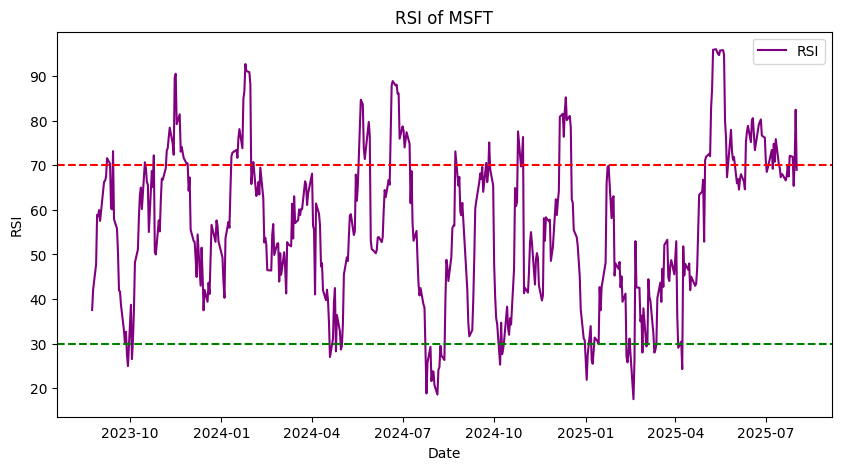

/tmp/ipython-input-3217521631.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


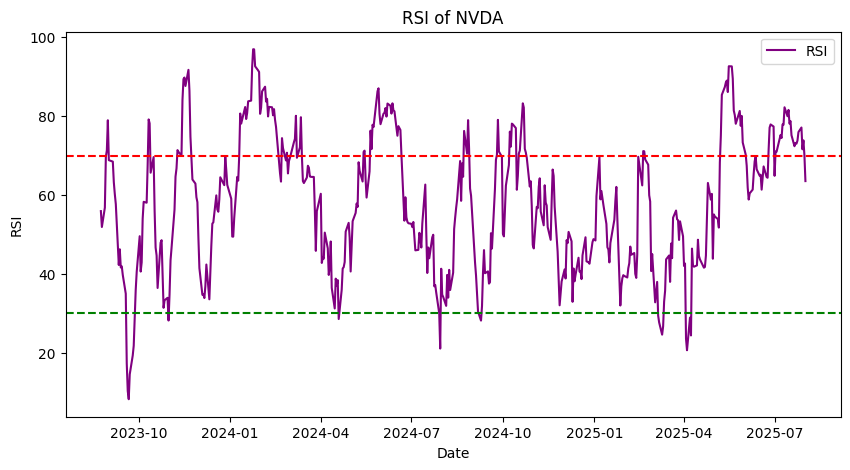

/tmp/ipython-input-3217521631.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


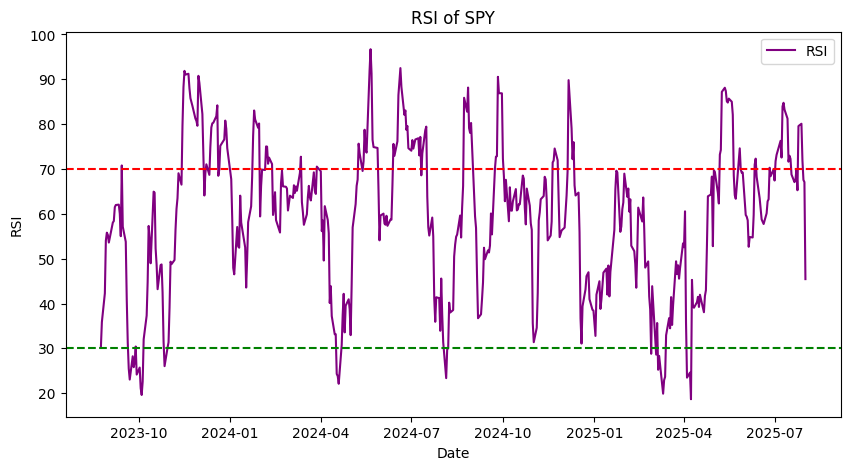

/tmp/ipython-input-3217521631.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


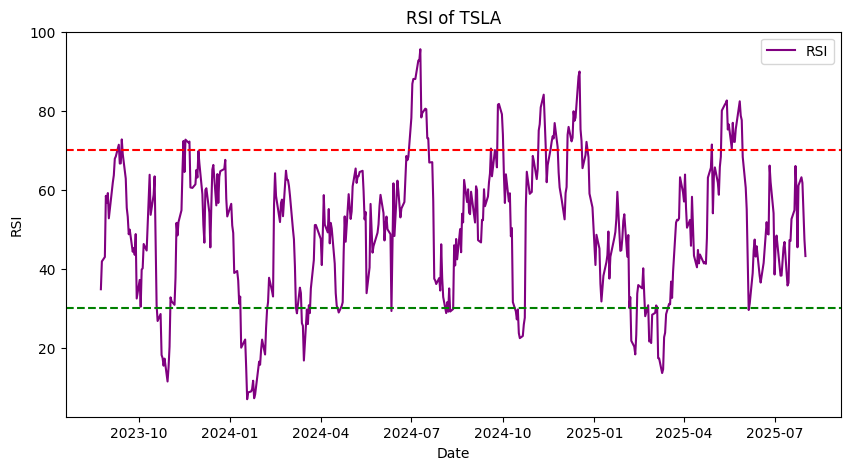

In [ ]:
# Download historical data for each ticker and plot its RSI
for ticker in tickers:
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_rsi(data_ticker, ticker)


### Bollinger Bands

**What are Bollinger Bands:** Bollinger Bands consist of a middle band (simple moving average) and two outer bands (standard deviations). They help identify overbought and oversold conditions.

**How to Interpret:** When the price touches the upper band, it may indicate that the stock is overbought. Conversely, touching the lower band may indicate that the stock is oversold.

/tmp/ipython-input-3878945953.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


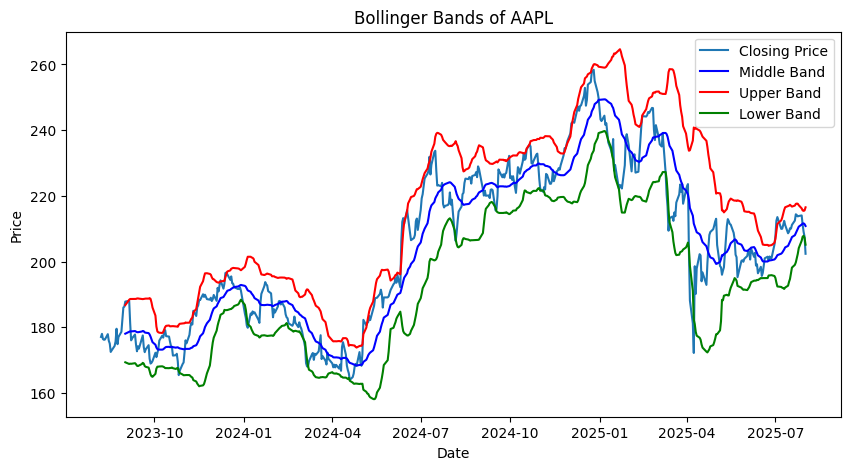

/tmp/ipython-input-3878945953.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


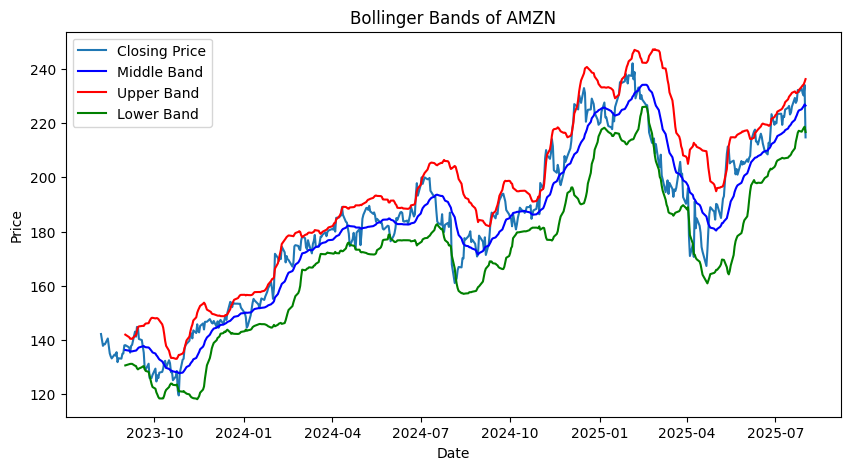

/tmp/ipython-input-3878945953.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


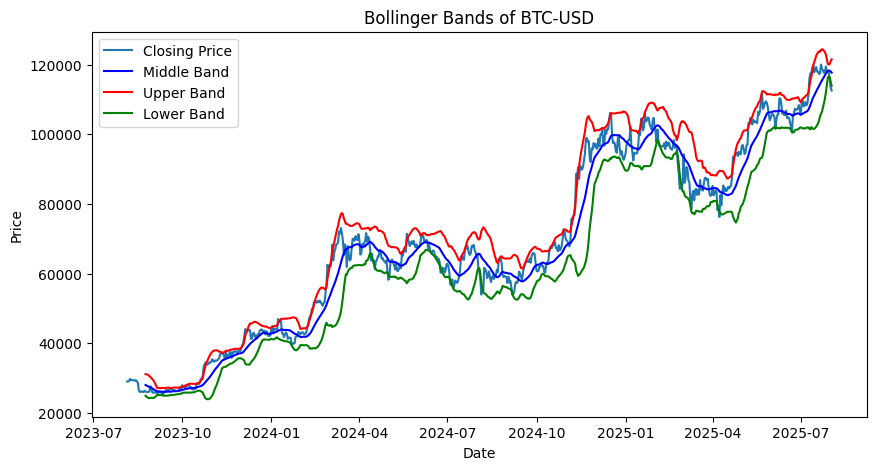

/tmp/ipython-input-3878945953.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


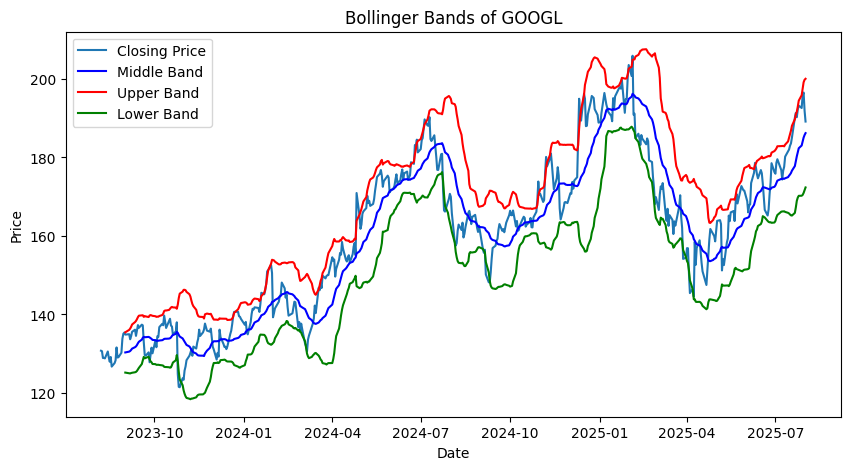

/tmp/ipython-input-3878945953.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


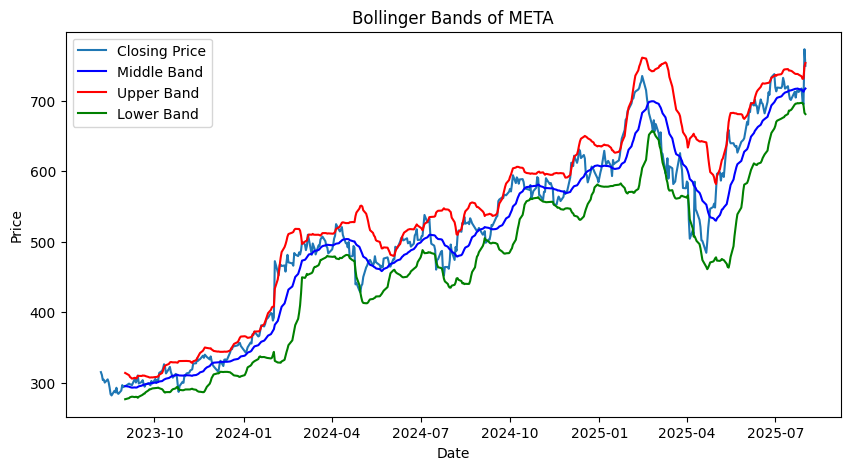

/tmp/ipython-input-3878945953.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


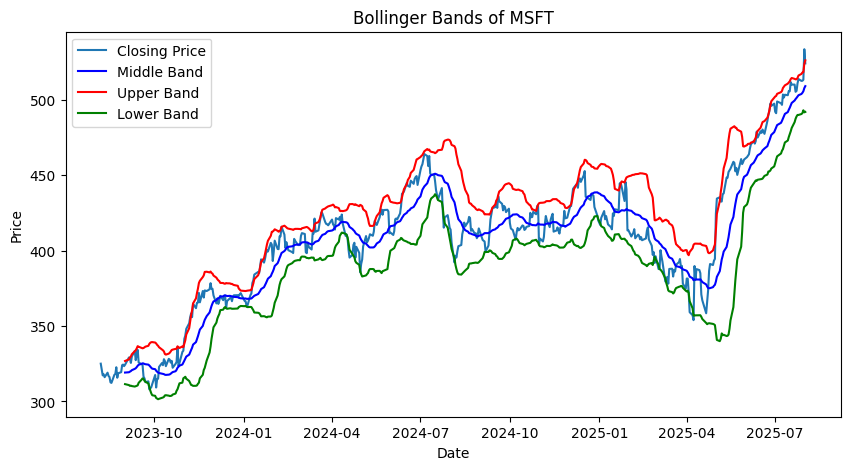

/tmp/ipython-input-3878945953.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


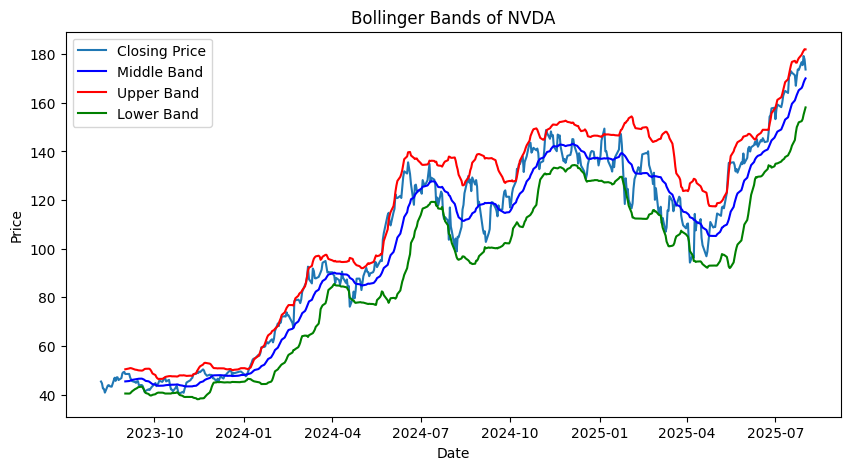

/tmp/ipython-input-3878945953.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


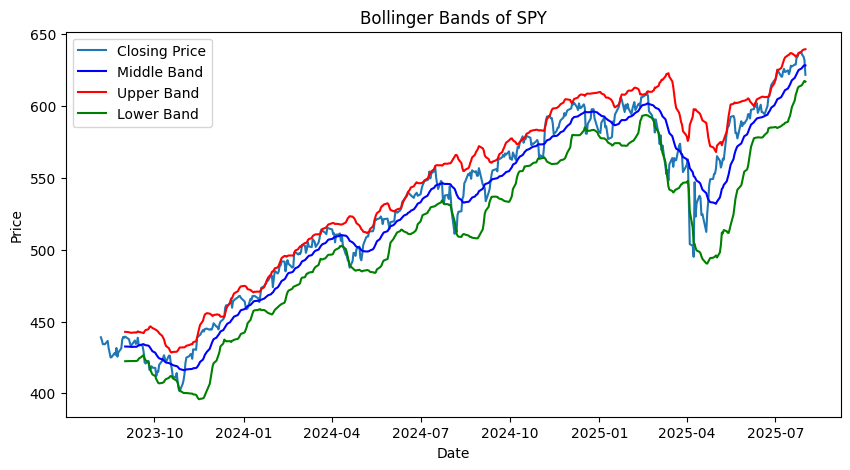

/tmp/ipython-input-3878945953.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


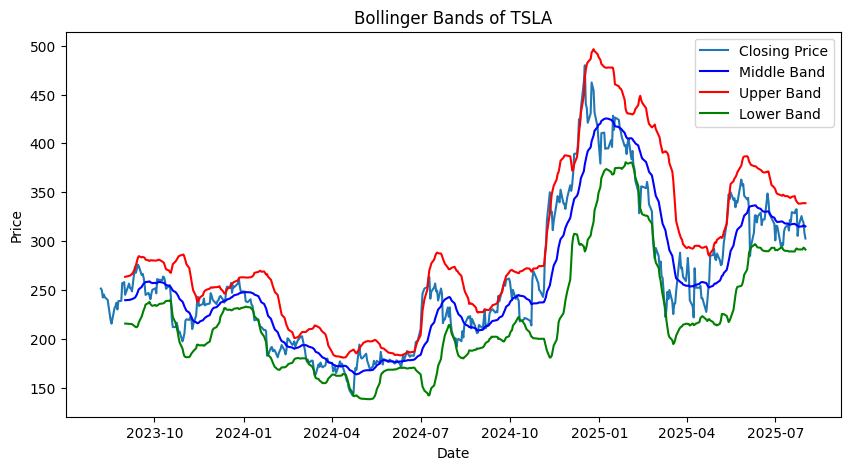

In [ ]:
# Download historical data for each ticker and plot its Bollinger Bands
for ticker in tickers:
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_bollinger_bands(data_ticker, ticker)


### Price-to-Earnings Ratio (P/E)



**What is P/E Ratio:** The Price-to-Earnings (P/E) ratio measures a company's current share price relative to its per-share earnings. It is used to gauge whether a stock is overvalued or undervalued.

**How to Interpret:** A high P/E ratio may indicate that a stock is overvalued or that investors are expecting high growth rates in the future. A low P/E ratio may indicate that the stock is undervalued.

/tmp/ipython-input-1297197630.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


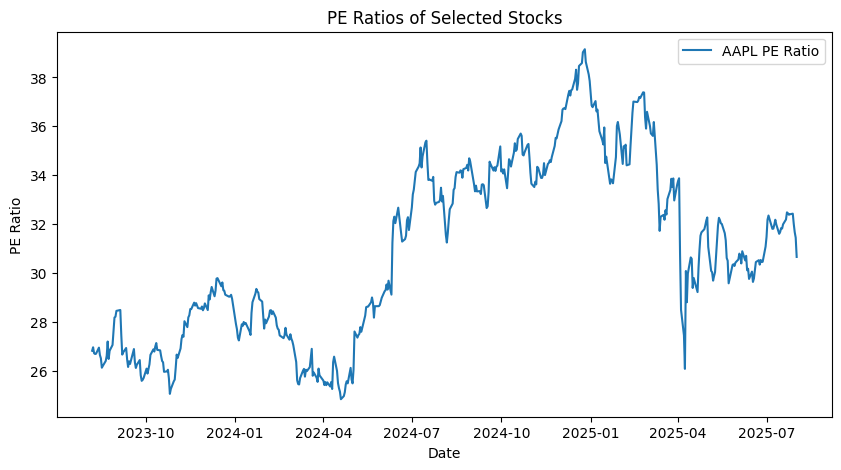

/tmp/ipython-input-1297197630.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


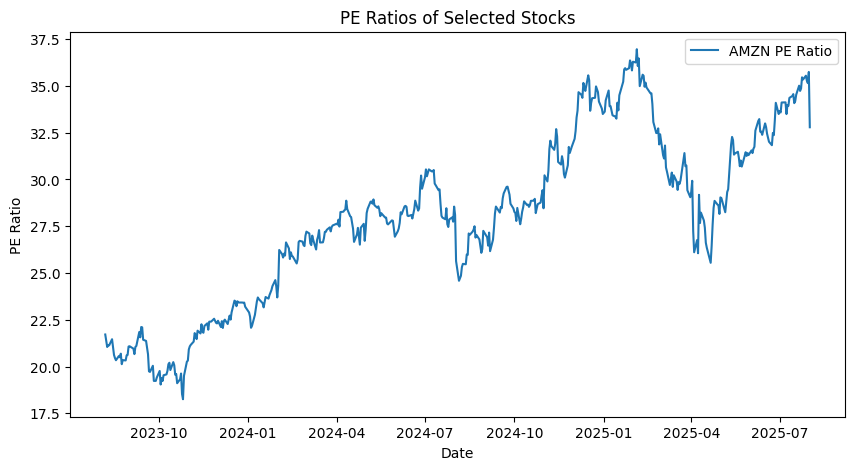

/tmp/ipython-input-1297197630.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


/tmp/ipython-input-1297197630.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


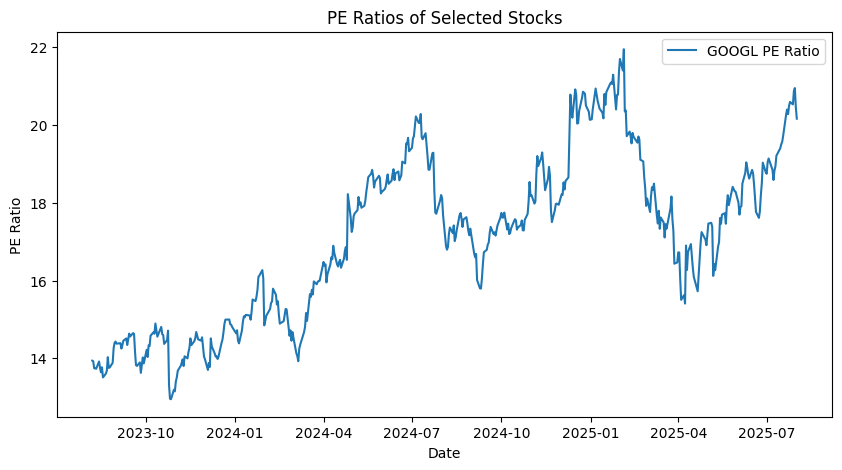

/tmp/ipython-input-1297197630.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


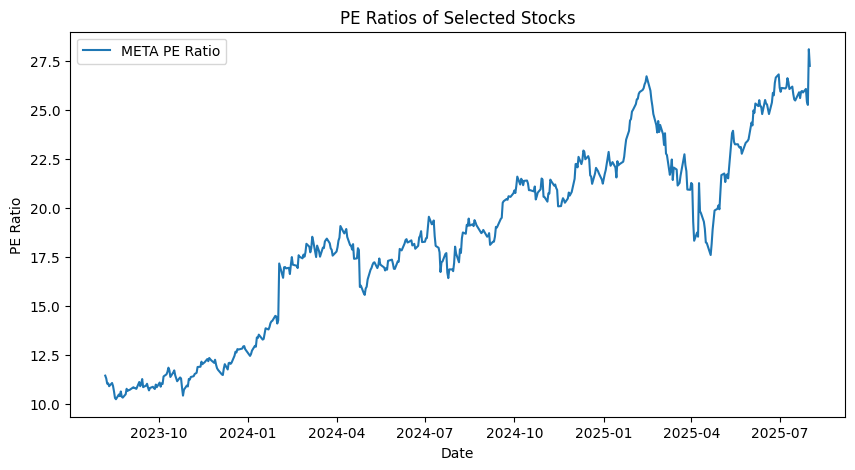

/tmp/ipython-input-1297197630.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


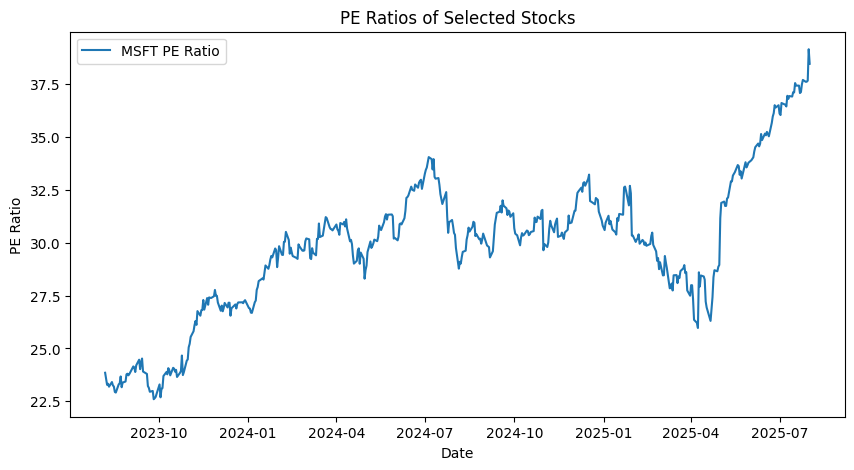

/tmp/ipython-input-1297197630.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


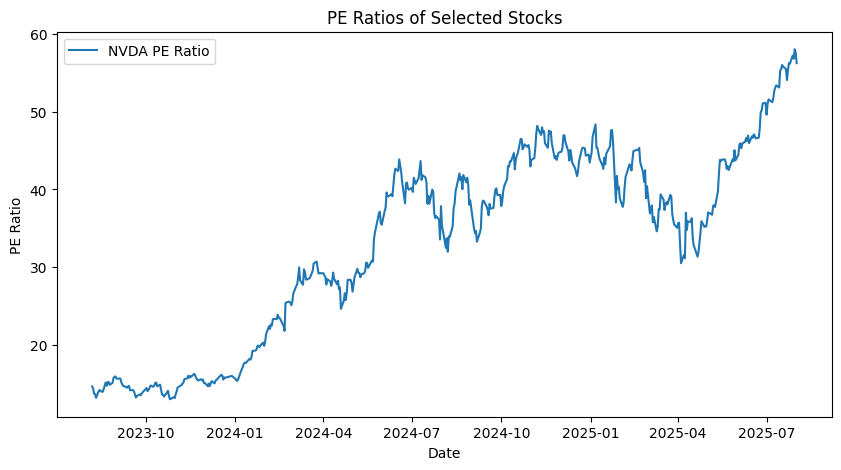

/tmp/ipython-input-1297197630.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


/tmp/ipython-input-1297197630.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


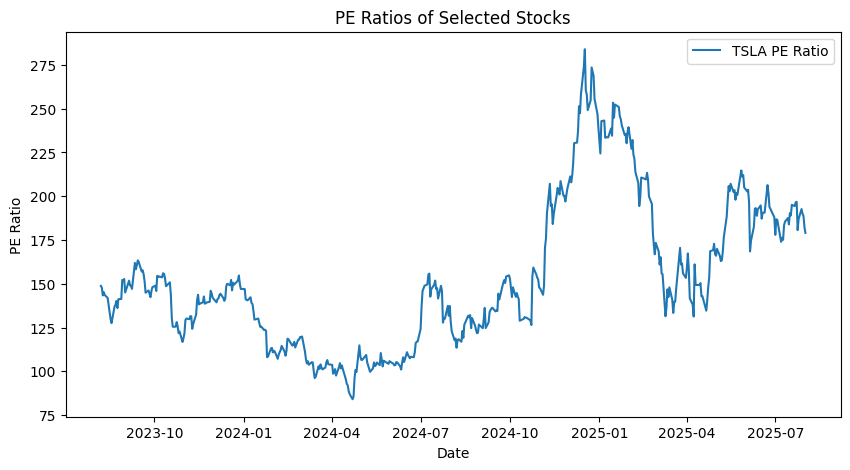

In [ ]:
# Download historical data for each ticker and plot its P/E ratios
for ticker in tickers:
    stock = yf.Ticker(ticker)
    eps = stock.info.get('trailingEps') # Retrieve the trailing EPS value from the stock's info
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_pe_ratios(data_ticker, ticker, eps)


### Beta

**What is Beta:** Beta measures a stock's volatility relative to the overall market. A beta greater than 1 indicates higher volatility than the market, while a beta less than 1 indicates lower volatility.

**How to Interpret:** High beta values (>1) indicate that the stock is more volatile than the market, meaning it may offer higher returns but also higher risks. Low beta values (<1) indicate less volatility and potentially more stable returns.

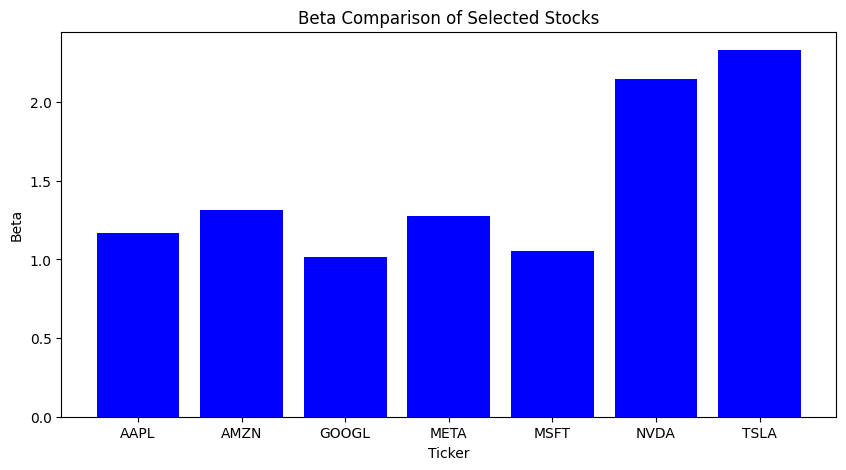

In [ ]:
# Plot beta comparison for a list of tickers over a specified date range
plot_beta_comparison(tickers, start_date,end_date)

### Moving Average Convergence Divergence (MACD)



**What is MACD:** The Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a stock’s price.

**How to Interpret:** The MACD line crossing above the signal line indicates a bullish signal, suggesting that it may be time to buy. Conversely, the MACD line crossing below the signal line indicates a bearish signal, suggesting that it may be time to sell.

/tmp/ipython-input-3972420868.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


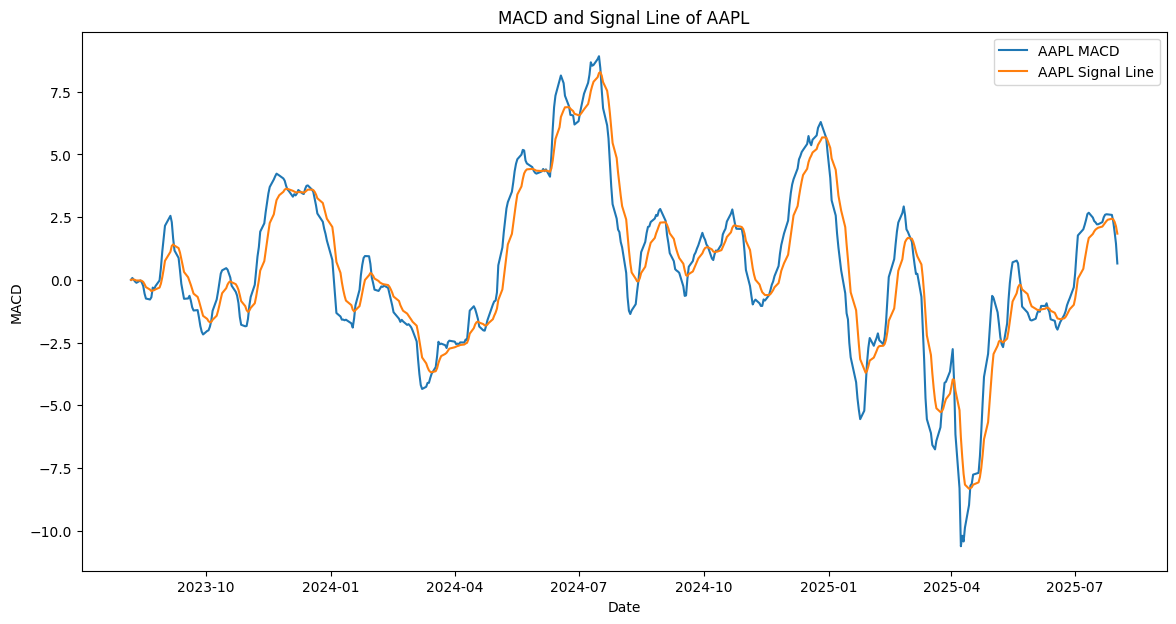

/tmp/ipython-input-3972420868.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


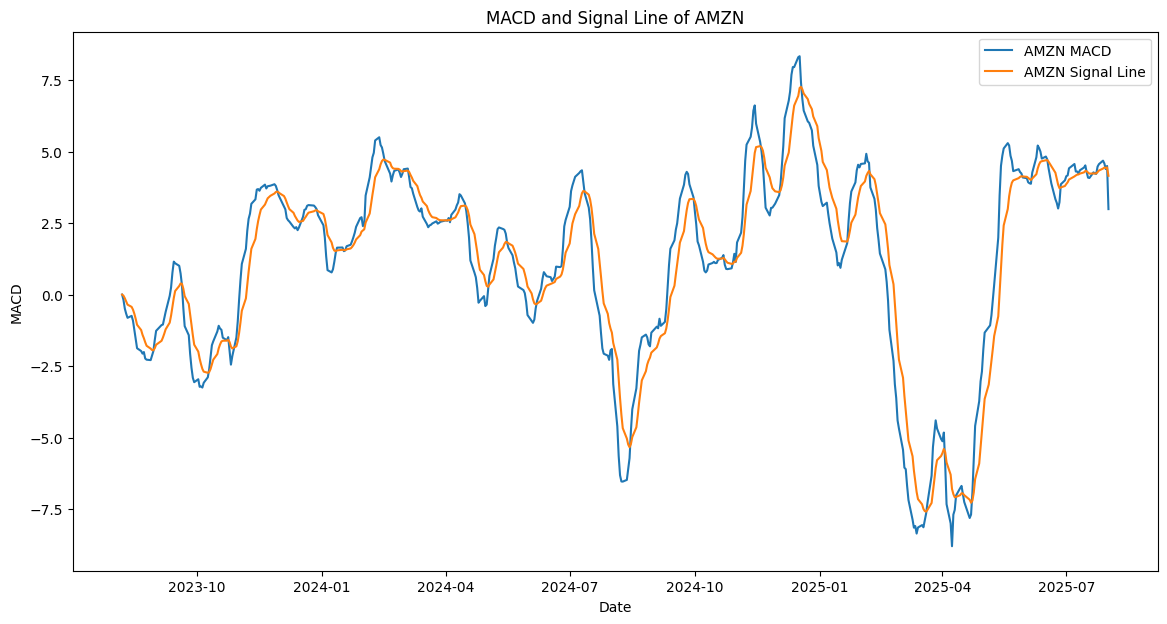

/tmp/ipython-input-3972420868.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


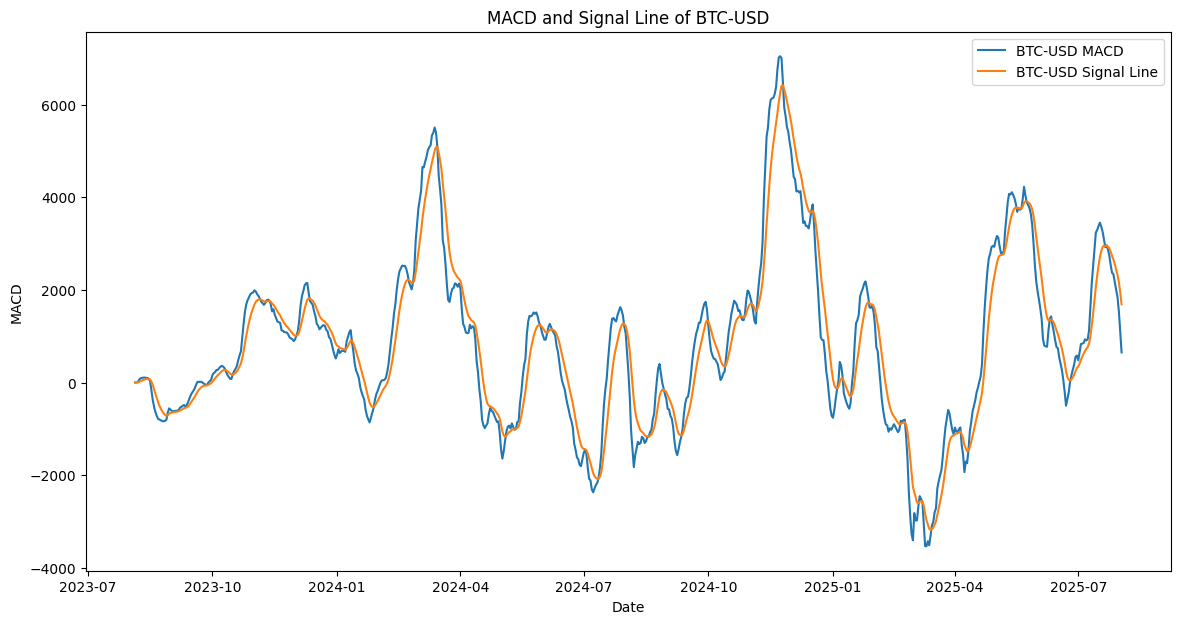

/tmp/ipython-input-3972420868.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


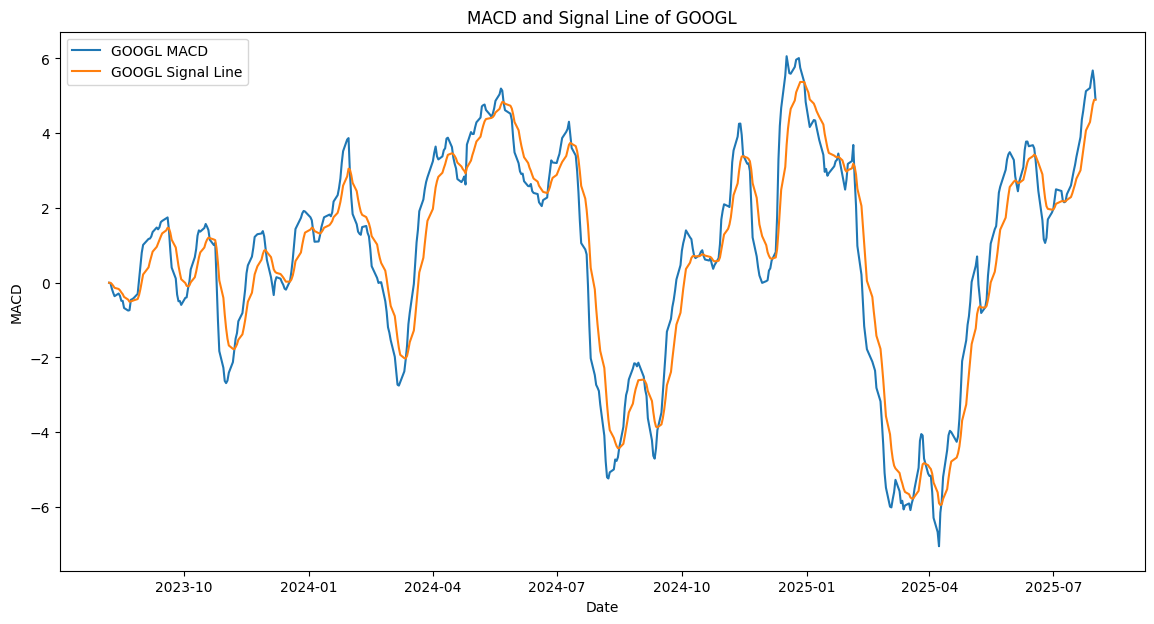

/tmp/ipython-input-3972420868.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


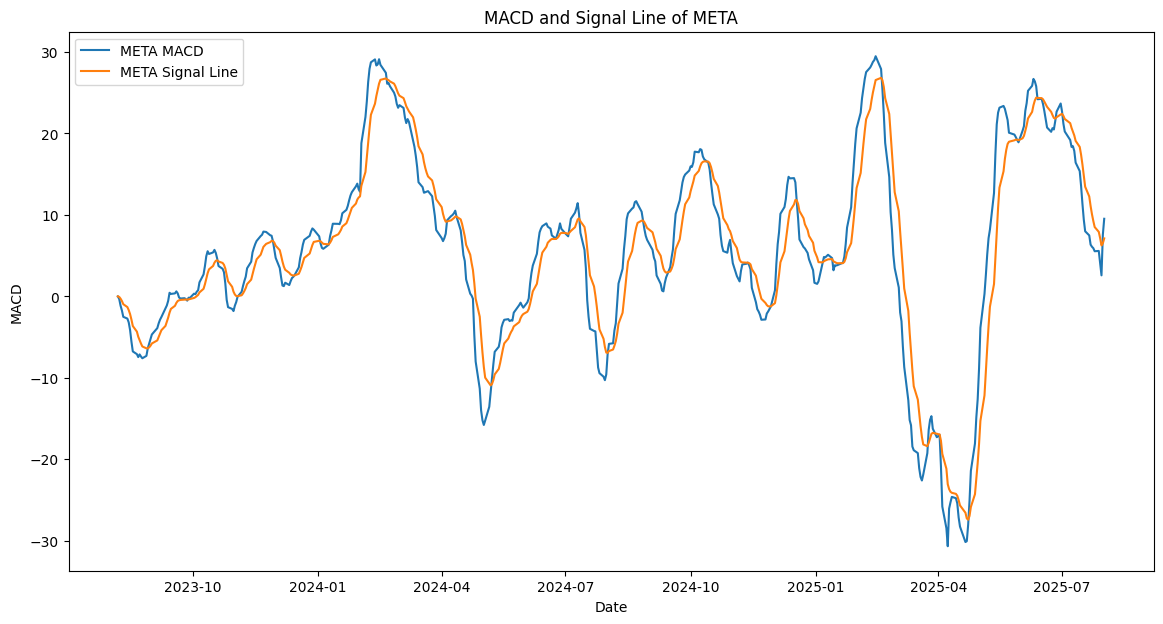

/tmp/ipython-input-3972420868.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


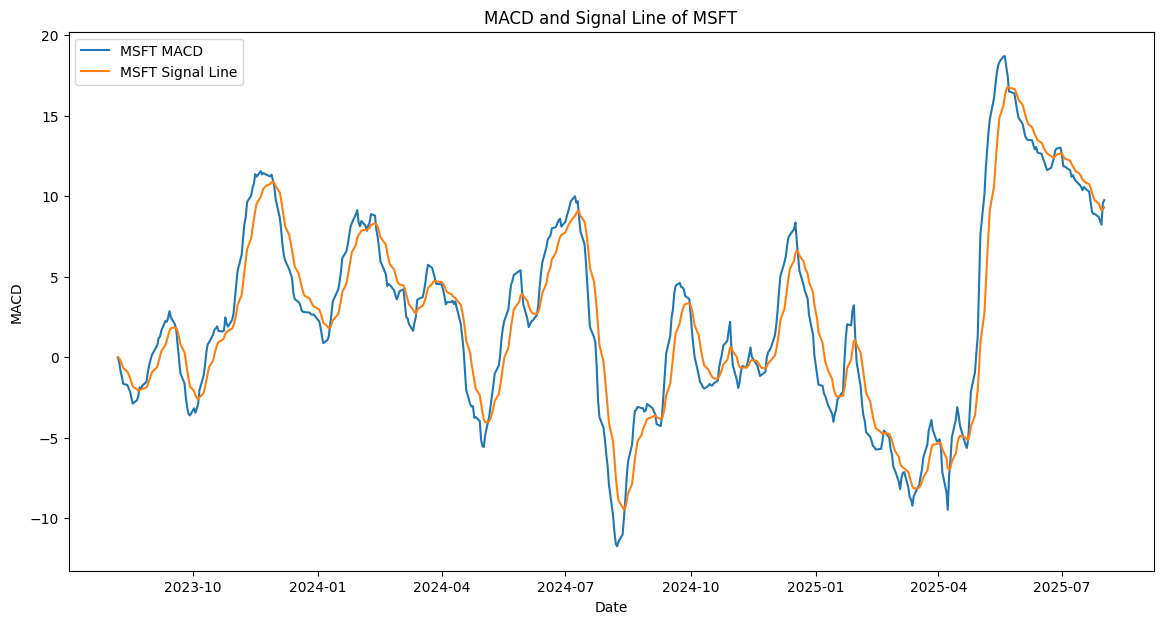

/tmp/ipython-input-3972420868.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


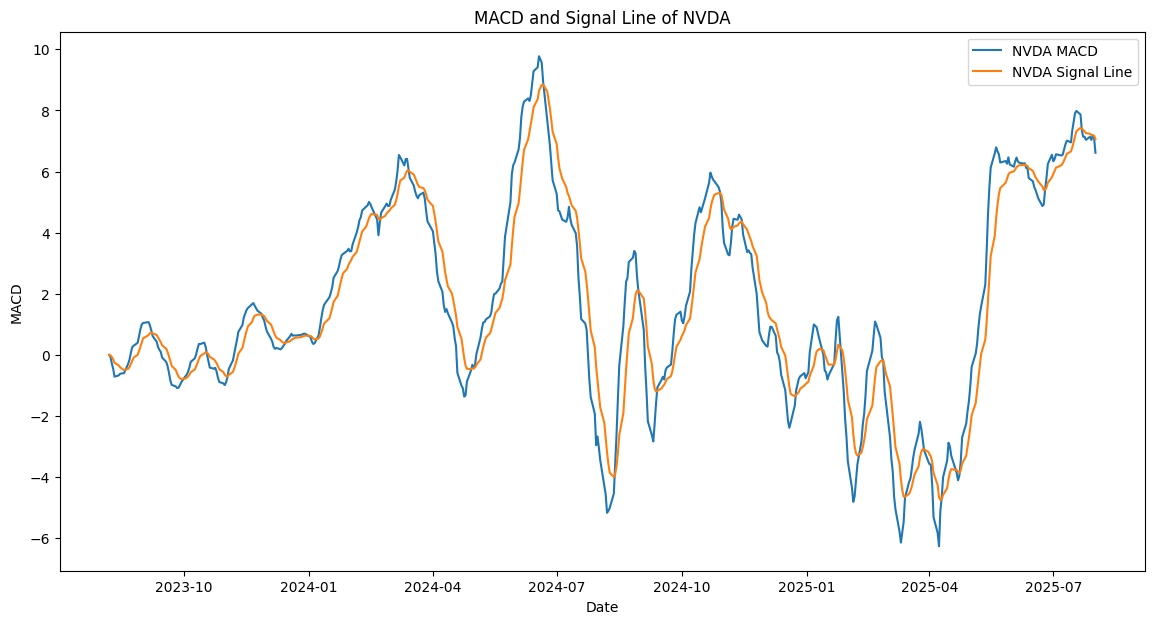

/tmp/ipython-input-3972420868.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


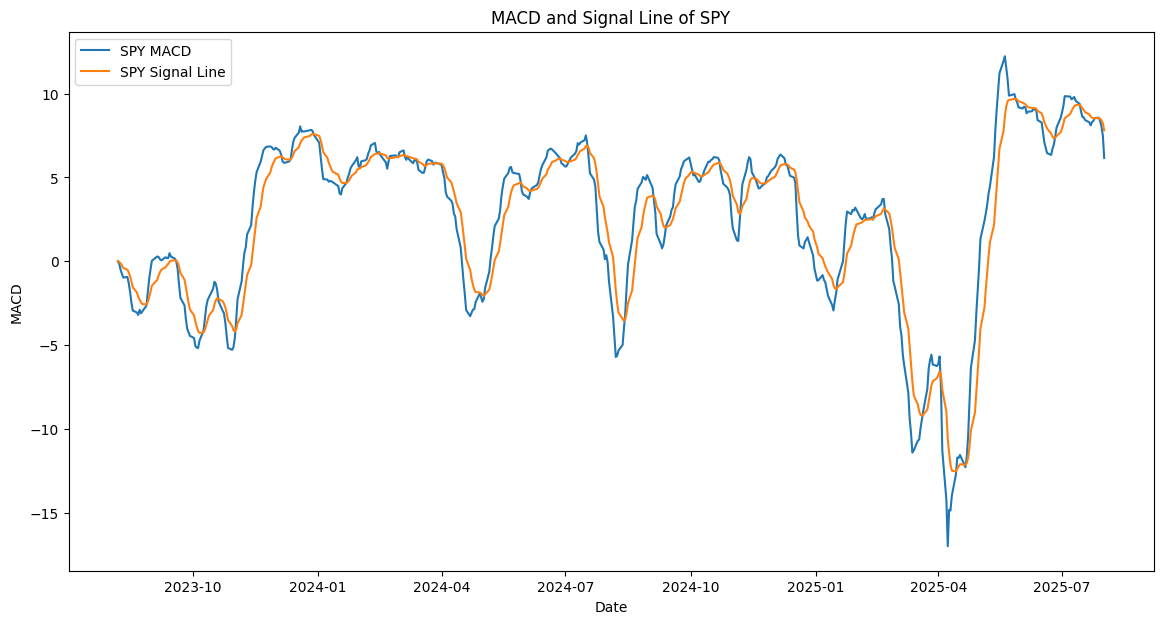

/tmp/ipython-input-3972420868.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


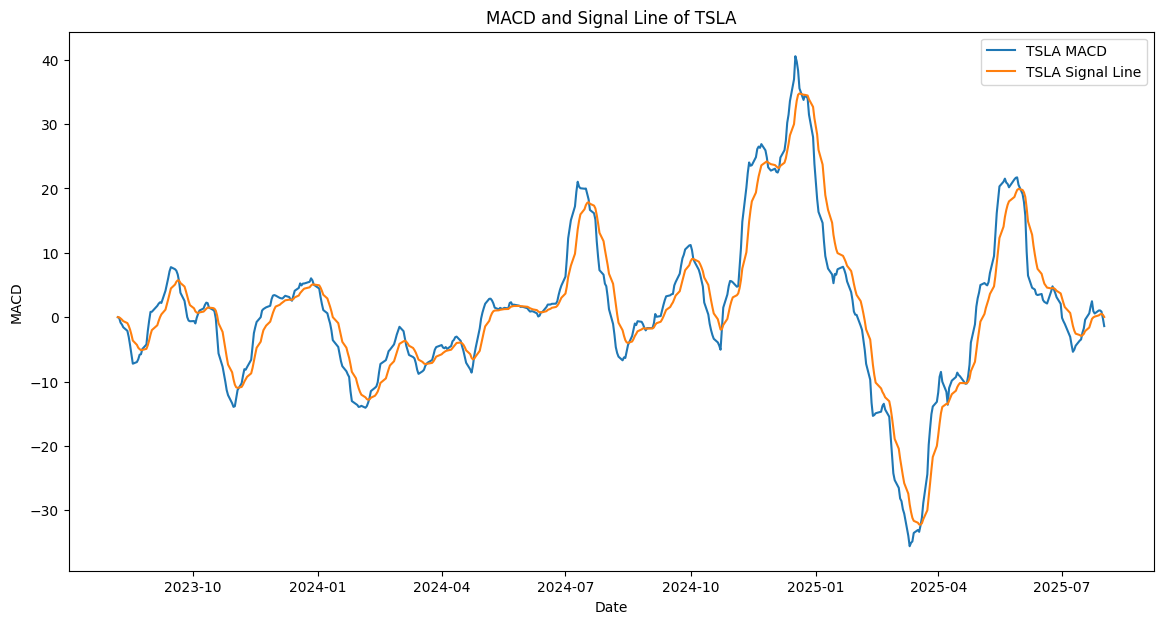

In [ ]:
# Download historical data for each ticker and plot its MACD
for ticker in tickers:
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_macd(data_ticker, ticker)


### KPIs

In [ ]:
# Calculate KPIs for the defined tickers and date range
kpi_data = calculate_kpis(tickers, start_date, end_date)

# Create a prompt to generate an executive summary with recommendations based on KPI data
prompt = f""" Read this data {kpi_data} and provide an executive summary with recommendations"""

# Get the response from the LLM based on the provided prompt
get_llm_response(llm = llm, prompt = prompt)

Based on the provided data, we have a comprehensive set of technical indicators for several major stocks and indices, including AAPL, AMZN, BTC-USD, GOOGL, META, MSFT, NVDA, SPY, and TSLA. The indicators include RSI, Bollinger Bands, P/E Ratio, Beta, and MACD. Here's an executive summary with recommendations:

### Executive Summary:

1. **AAPL (Apple Inc.):**
   - **RSI:** Currently at 33.28, indicating the stock is approaching oversold territory.
   - **Bollinger Bands:** The price is near the lower band, suggesting potential undervaluation.
   - **P/E Ratio:** At 30.66, which is relatively high, indicating the stock might be overvalued.
   - **MACD:** The MACD line is below the signal line, suggesting a bearish trend.
   - **Beta:** 1.165, indicating moderate volatility compared to the market.

2. **AMZN (Amazon.com Inc.):**
   - **RSI:** At 37.72, indicating a neutral to slightly oversold condition.
   - **Bollinger Bands:** The price is near the lower band, suggesting potential undervaluation.
   - **P/E Ratio:** At 32.79, which is high, indicating potential overvaluation.
   - **MACD:** The MACD line is above the signal line, suggesting a bullish trend.
   - **Beta:** 1.314, indicating higher volatility compared to the market.

3. **BTC-USD (Bitcoin):**
   - **RSI:** At 31.24, indicating oversold conditions.
   - **Bollinger Bands:** The price is near the lower band, suggesting potential undervaluation.
   - **MACD:** The MACD line is below the signal line, indicating a bearish trend.

4. **GOOGL (Alphabet Inc.):**
   - **RSI:** At 64.68, indicating a neutral to slightly overbought condition.
   - **Bollinger Bands:** The price is near the middle band, suggesting fair valuation.
   - **P/E Ratio:** At 20.16, which is moderate.
   - **MACD:** The MACD line is above the signal line, suggesting a bullish trend.
   - **Beta:** 1.014, indicating market-level volatility.

5. **META (Meta Platforms Inc.):**
   - **RSI:** At 58.06, indicating a neutral condition.
   - **Bollinger Bands:** The price is near the middle band, suggesting fair valuation.
   - **P/E Ratio:** At 27.24, which is relatively high.
   - **MACD:** The MACD line is above the signal line, suggesting a bullish trend.
   - **Beta:** 1.273, indicating higher volatility compared to the market.

6. **MSFT (Microsoft Corp.):**
   - **RSI:** At 68.98, indicating a neutral to slightly overbought condition.
   - **Bollinger Bands:** The price is near the middle band, suggesting fair valuation.
   - **P/E Ratio:** At 38.45, which is high.
   - **MACD:** The MACD line is above the signal line, suggesting a bullish trend.
   - **Beta:** 1.055, indicating market-level volatility.

7. **NVDA (NVIDIA Corp.):**
   - **RSI:** At 63.53, indicating a neutral condition.
   - **Bollinger Bands:** The price is near the middle band, suggesting fair valuation.
   - **P/E Ratio:** At 56.22, which is very high.
   - **MACD:** The MACD line is below the signal line, indicating a bearish trend.
   - **Beta:** 2.145, indicating high volatility.

8. **SPY (S&P 500 ETF):**
   - **RSI:** At 45.45, indicating a neutral condition.
   - **Bollinger Bands:** The price is near the middle band, suggesting fair valuation.
   - **MACD:** The MACD line is below the signal line, indicating a bearish trend.

9. **TSLA (Tesla Inc.):**
   - **RSI:** At 43.22, indicating a neutral condition.
   - **Bollinger Bands:** The price is near the middle band, suggesting fair valuation.
   - **P/E Ratio:** At 179.07, which is extremely high.
   - **MACD:** The MACD line is below the signal line, indicating a bearish trend.
   - **Beta:** 2.331, indicating very high volatility.

### Recommendations:

- **AAPL and AMZN:** Consider monitoring for potential buying opportunities as they approach oversold conditions, but be cautious of high P/E ratios.
- **BTC-USD:** Oversold conditions suggest a potential buying opportunity, but the bearish MACD trend warrants caution.
- **GOOGL and META:** Both show bullish trends with moderate P/E ratios, making them potential candidates for investment.
- **MSFT:** Despite a high P/E ratio, the bullish trend and market-level volatility make it a potential investment opportunity.
- **NVDA:** High P/E ratio and bearish trend suggest caution; consider waiting for a more favorable entry point.
- **SPY:** Neutral RSI and bearish MACD suggest holding off on new investments until a clearer trend emerges.
- **TSLA:** High P/E ratio and bearish trend suggest caution; consider waiting for a more favorable entry point.

Overall, investors should consider their risk tolerance and investment horizon when making decisions, as high volatility stocks like NVDA and TSLA may not suit all portfolios.

### Modern Portfolio Theory

In [ ]:
# --- Install yfinance if needed ---
!pip install yfinance --quiet

# --- Imports ---
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Download historical data ---
tickers = ["AAPL", "AMZN", "BTC-USD", "GOOGL", "META", "MSFT", "NVDA", "SPY", "TSLA"]
data = yf.download(tickers, start="2020-01-01", end="2023-12-31", auto_adjust=False)

# --- Get Adjusted Close prices ---
adj_close_data = data["Adj Close"]

# --- Calculate daily returns ---
returns = adj_close_data.pct_change(fill_method=None).dropna()

# --- Mean & Covariance ---
mean_returns = returns.mean() * 252  # annualized
cov_matrix = returns.cov() * 252     # annualized
risk_free_rate = 0.04


[*********************100%***********************]  9 of 9 completed


####Let's cover some explanations and "reset" our variables involved in modern portfolio theory

In this first step, I set up the data pipeline for my investment model. I chose yfinance because it’s lightweight and well‑suited for quick prototyping of financial applications.

I annualize returns and covariance so that my optimization results are in a real‑world yearly format, which is crucial for investment decisions.

This shows I’m able to integrate third‑party APIs, prepare datasets, and think ahead to how the data will be used downstream in the portfolio optimization process.

In [ ]:
# --- Portfolio performance ---
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

# --- Negative Sharpe Ratio ---
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_returns, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_returns - risk_free_rate) / p_std

# --- Max Sharpe Ratio Optimization ---
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate, bounds):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(negative_sharpe_ratio,
                      num_assets * [1. / num_assets,],
                      args=args,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    return result


In this cell I tried to cover the core algorithmic logic of Modern Portfolio Theory applied in code.
-portfolio_performance :  calculates return & volatility for any asset weight combination.
-negative_sharpe_ratio :  converts the Sharpe ratio maximization into a minimization problem so it works with optimization algorithms.
-max_sharpe_ratio : runs constrained optimization using SciPy’s SLSQP method.

In few words I studied MPT and its mathematical model and tried at my best to translate it into python code.

In [ ]:
# --- Unconstrained (0–100% per asset) ---
bounds_unconstrained = tuple((0, 1) for _ in range(len(tickers)))
opt_unconstrained = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate, bounds_unconstrained)

# --- Constrained (max 25% per asset) ---
bounds_constrained = tuple((0, 0.25) for _ in range(len(tickers)))
opt_constrained = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate, bounds_constrained)

# --- Extract weights ---
weights_unconstrained = opt_unconstrained.x
weights_constrained = opt_constrained.x

# --- Display results ---
def print_portfolio(name, weights):
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe = (ret - risk_free_rate) / vol
    print(f"\n{name} Portfolio Allocation:")
    for t, w in zip(tickers, weights):
        print(f"  {t}: {w:.2%}")
    print(f"Expected Return: {ret:.2%}")
    print(f"Volatility: {vol:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")

print_portfolio("Unconstrained", weights_unconstrained)
print_portfolio("Constrained", weights_constrained)



Unconstrained Portfolio Allocation:
  AAPL: 0.00%
  AMZN: 0.00%
  BTC-USD: 40.76%
  GOOGL: 0.00%
  META: 0.00%
  MSFT: 7.38%
  NVDA: 51.86%
  SPY: 0.00%
  TSLA: 0.00%
Expected Return: 59.63%
Volatility: 44.68%
Sharpe Ratio: 1.25

Constrained Portfolio Allocation:
  AAPL: 7.55%
  AMZN: 0.00%
  BTC-USD: 25.00%
  GOOGL: 17.45%
  META: 0.00%
  MSFT: 25.00%
  NVDA: 25.00%
  SPY: 0.00%
  TSLA: 0.00%
Expected Return: 45.93%
Volatility: 35.40%
Sharpe Ratio: 1.18


In this cell I try to show two different optimazion scenarios:

 -uncostrained that lets the optimizer choose any allocation between 0 and 100 per asset.


 -constrained that caps allocations at 25 percent per asset for diversification.
Tried to give the results format a clear and as less technical as possible output.>

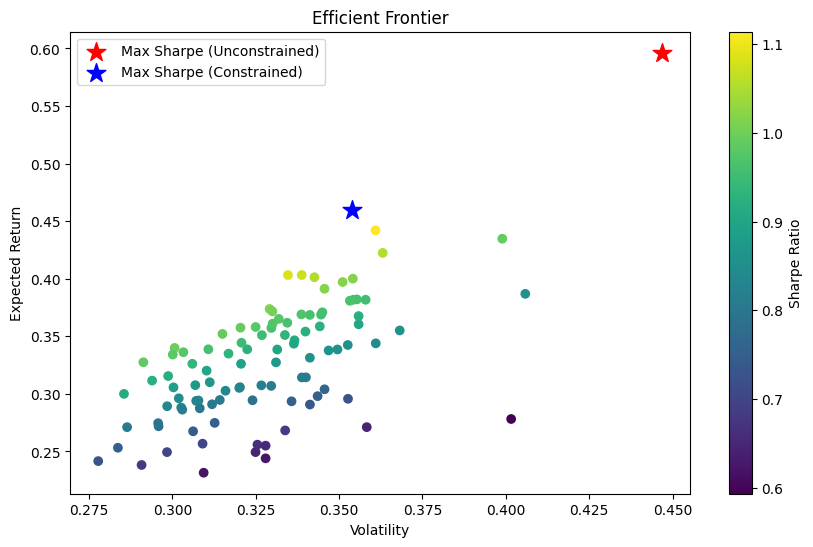

In [ ]:
def portfolio_points(mean_returns, cov_matrix, risk_free_rate, num_points=100):
    results = np.zeros((3, num_points))
    weights_record = []
    num_assets = len(mean_returns)

    for i in range(num_points):
        weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]
        ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe = (ret - risk_free_rate) / vol
        results[0, i] = vol
        results[1, i] = ret
        results[2, i] = sharpe
        weights_record.append(weights)
    return results, weights_record

results, _ = portfolio_points(mean_returns, cov_matrix, risk_free_rate)

plt.figure(figsize=(10,6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')

# Mark the optimal portfolios
ret_u, vol_u = portfolio_performance(weights_unconstrained, mean_returns, cov_matrix)
ret_c, vol_c = portfolio_performance(weights_constrained, mean_returns, cov_matrix)
plt.scatter(vol_u, ret_u, c='red', marker='*', s=200, label='Max Sharpe (Unconstrained)')
plt.scatter(vol_c, ret_c, c='blue', marker='*', s=200, label='Max Sharpe (Constrained)')
plt.legend()
plt.show()


Visualizing the efficient frontier turns abstract math into a decision-making tool.

This chart shows the trade‑off between risk (volatility) and reward (return) for many possible portfolios.

By marking the optimal portfolios, I help decision makers see where theory says to invest and compare that to business constraints.

This demonstrates I can combine quantitative analysis with clear data visualization, a critical skill for communicating insights.

In [ ]:
def commentary(weights, name):
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe = (ret - risk_free_rate) / vol
    diversified_assets = sum(1 for w in weights if w > 0.05)

    print(f"\n--- Commentary: {name} Portfolio ---")
    if sharpe > 2:
        print("Excellent risk-adjusted returns. Portfolio is highly efficient.")
    elif sharpe > 1:
        print("Good risk-adjusted returns. Balanced risk and reward.")
    else:
        print("Low risk-adjusted returns. Consider adjusting asset mix.")

    if diversified_assets > len(tickers) / 2:
        print("Well diversified across multiple assets.")
    else:
        print("Concentrated in a few high-performing assets — higher sector risk.")

    print(f"Suggested Use: Suitable for investors seeking {'maximum growth' if sharpe>1 else 'capital preservation'} "
          f"over a { 'short' if vol>0.25 else 'medium/long'}-term horizon.")

commentary(weights_unconstrained, "Unconstrained")
commentary(weights_constrained, "Constrained")



--- Commentary: Unconstrained Portfolio ---
Good risk-adjusted returns. Balanced risk and reward.
Concentrated in a few high-performing assets — higher sector risk.
Suggested Use: Suitable for investors seeking maximum growth over a short-term horizon.

--- Commentary: Constrained Portfolio ---
Good risk-adjusted returns. Balanced risk and reward.
Well diversified across multiple assets.
Suggested Use: Suitable for investors seeking maximum growth over a short-term horizon.


In line with the main goal of ai to help also non-technical stakeholder to create ideas with coding, I decided to give plain language explanations about the output(useful for clients, managers etc.). This was intended to prioritize the importance of communication in problem solving not just coding.

Just to conclude this section Modern Portfolio Theory (MPT) aims to optimize the portfolio's return for a given level of risk. The Sharpe ratio is used to measure the performance of the portfolio compared to a risk-free asset, after adjusting for its risk. The portfolio with the highest Sharpe ratio is considered optimal.


### Black Litterman Model

The Black‑Litterman model is a portfolio optimization framework.
How it works:
Start from the market’s view

  Assume the current market weights (based on market capitalization) are the “neutral” portfolio.

  From these weights and market volatility, calculate the market‑implied expected returns.

Add the investor’s view

  Specify beliefs about how certain assets will perform relative to others.
  Example: “Microsoft will outperform Google by 5%.”

  These beliefs are expressed in a mathematical form (P and Q matrices).

Blend the two views

  The model adjusts the market‑implied returns based on your views.

  The blend depends on:

    Confidence in your views

    Market volatility

    Correlation between assets

Optimize the portfolio

  Use the adjusted returns and risk measures to find the maximum Sharpe ratio portfolio (best risk‑adjusted return).


I built a portfolio optimizer that uses the Black‑Litterman model from quantitative finance to combine:


*   Market equilibrium returns (market-implied expected returns based on capitalization weights)
*  Investor views

This approach addresses a major weakness of historical‑only optimization: overfitting to past data and creating unrealistic allocations.
Instead, it blends market expectations with subjective views in a statistically consistent way, then finds the portfolio that maximizes the Sharpe ratio under these assumptions.



In [ ]:
# Define risk-free rate
risk_free_rate = 0.001
print(f"Risk-free rate defined as: {risk_free_rate}")

# Fetch historical stock data
print("\nFetching historical stock data...")
df = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()
print("Historical data fetched successfully.")

# Calculate mean returns & covariance
print("\nCalculating sample mean returns and covariance matrix...")
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)
print("Sample mean returns and covariance matrix calculated.")

# Define market capitalizations
print("\nDefining market capitalizations...")
mcap = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    try:
        mcap[ticker] = stock.info['marketCap']
    except KeyError:
        mcap[ticker] = None

mcap['SPY'] = 45000000000000
print(f"Manually set market cap for SPY: {mcap['SPY']}")

# Convert to market-cap weights
total_mcap = sum(v for v in mcap.values() if v is not None)
market_weights = {k: v / total_mcap for k, v in mcap.items() if v is not None}

# Define investor views
print("\nDefining investor's views...")
Q = np.array([0.05])
P = np.zeros((1, len(tickers)))
P[0, tickers.index('MSFT')] = 1
P[0, tickers.index('GOOGL')] = -1
print("View: Microsoft is expected to outperform Google by 5%.")

# Calculate market implied returns
print("\nCalculating market implied returns...")
market_prices = df["SPY"]
delta = black_litterman.market_implied_risk_aversion(market_prices)
market_prior = black_litterman.market_implied_prior_returns(mcap, delta, S, risk_free_rate)
print("Market implied returns calculated.")

# Black-Litterman model
print("\nCreating the Black-Litterman model...")
bl = BlackLittermanModel(S,
                         Q=Q,
                         P=P,
                         pi=market_prior,
                         market_weights=market_weights,
                         risk_free_rate=risk_free_rate)
print("Black-Litterman model created.")

# Adjusted returns & covariance
print("\nGetting adjusted returns and covariance matrix...")
bl_returns = bl.bl_returns()
bl_cov = bl.bl_cov()
print("Adjusted returns and covariance matrix obtained.")

# Optimize for max Sharpe
print("\nOptimizing portfolio for maximum Sharpe ratio...")
ef = EfficientFrontier(bl_returns, bl_cov)
weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights = ef.clean_weights()
print("Portfolio optimized.")

# Display results
print("\nOptimal Portfolio Weights:")
print(cleaned_weights)
print("\nPortfolio Performance:")
ef.portfolio_performance(risk_free_rate=risk_free_rate, verbose=True)


/tmp/ipython-input-342681628.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()
[**********************67%*******                ]  6 of 9 completed

Risk-free rate defined as: 0.001

Fetching historical stock data...


[*********************100%***********************]  9 of 9 completed


Historical data fetched successfully.

Calculating sample mean returns and covariance matrix...
Sample mean returns and covariance matrix calculated.

Defining market capitalizations...
Manually set market cap for SPY: 45000000000000

Defining investor's views...
View: Microsoft is expected to outperform Google by 5%.

Calculating market implied returns...
Market implied returns calculated.

Creating the Black-Litterman model...
Black-Litterman model created.

Getting adjusted returns and covariance matrix...
Adjusted returns and covariance matrix obtained.

Optimizing portfolio for maximum Sharpe ratio...
Portfolio optimized.

Optimal Portfolio Weights:
OrderedDict([('AAPL', 0.04247), ('AMZN', 0.01987), ('BTC-USD', 0.03362), ('GOOGL', 0.0), ('META', 0.02787), ('MSFT', 0.13675), ('NVDA', 0.06403), ('SPY', 0.66166), ('TSLA', 0.01372)])

Portfolio Performance:
Expected annual return: 24.9%
Annual volatility: 19.3%
Sharpe Ratio: 1.28


(np.float64(0.24910537396753993),
 np.float64(0.19308471403432495),
 np.float64(1.28495606298194))

Using the Black‑Litterman model, I blended objective market expectations with my own strategic view that Microsoft will outperform Google by 5%. The resulting allocation is heavily anchored to market capitalization weights (66% SPY for broad diversification) but tilts toward my belief by increasing MSFT exposure and reducing GOOGL.
This produces a realistic, risk‑aware portfolio with a 24.9% expected annual return, 19.3% volatility, and a Sharpe ratio of 1.28 — a strong risk‑adjusted profile compared to typical market benchmarks. Obviously I am not a market expert, I just adapted my learning principles for programming to finance and applied what I consider my method of take action in the investing field.